### Import libraries

In [1]:
import os
import keyring
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from datetime import datetime

OPENAI_API_KEY = keyring.get_password('openai', 'key_for_windows')
ANTHROPIC_API_KEY = keyring.get_password('anthropic', 'key_for_windows')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['ANTHROPIC_API_KEY'] = ANTHROPIC_API_KEY
llm = ChatOpenAI(model='gpt-4p-mini')
today = datetime.today().date().strftime('%Y-%m-%d')
today


'2024-12-16'

In [2]:
# import market tools and analysis tools
from market_tools import *
from analysis_tools import *

USER_AGENT environment variable not set, consider setting it to identify your requests.


### Graph State와 에이전트 정의

In [3]:
# define a graph state and an agent
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import BaseMessage
from typing import TypedDict, Annotated, List
import operator

#2. define a state
class AnalysisState(TypedDict):
    company: str
    messages: Annotated[List[BaseMessage], operator.add]
    analyses: Annotated[List[dict], operator.add]       # accumulate analysis
    combined_report: str
    
#3. set a analysis agent and prompt
llm = ChatOpenAI(model='gpt-4o-mini')

financial_prompt = f"""
오늘은 {today}입니다.
당신은 뛰어난 재무 분석가입니다. 아래 임무를 지키면서, 데이터를 분석하고, 차트를 생성 및 저장해야 합니다.
당신의 임무는:
1. 회사의 재무 설명서를 면밀히 분석하여 숨겨진 통찰력을 발견하는 것
2. 주요 재무 비율을 계산하고 그 의미를 명확히 해석하는 것
3. 수익, 수익성, 현금 흐름의 추세를 파악하고 그에 따른 전략을 제안하는 것
4. 회사의 재무 건강 상태와 지속 가능성을 종합적으로 평가하는 것
5. 산업 표준과 비교하여 경쟁력을 분석하는 것

당신의 추론을 명확히 설명하고, 특정 지표로 결론을 뒷받침하세요.
분석을 철저히 하되, 객관성을 유지하는 것을 잊지 마세요.
"""

stock_prompt = f"""
오늘은 {today}입니다.
당신은 전문 주식 시장 분석가입니다. 아래 임무를 지키면서, 데이터를 분석하고, 차트를 생성 및 저장해야 합니다.
당신의 임무는:
1. 역사적 주식 가격 움직임을 분석하여 패턴을 식별하는 것
2. 기술 지표와 패턴을 평가하여 미래의 가격 변동을 예측하는 것
3. 시장 분위기와 모멘텀을 분석하여 투자 기회를 포착하는 것
4. 동료 기업과의의 가치 평가 지표를 비교하여 상대적 가치를 판단하는 것
5. 주요 가격 동인과 촉매를 식별하여 투자 전략을 수립하는 것

분석을 지원하는 구체적인 데이터 포인트와 차트를 제공하세요.
기술적 및 근본적 요소를 모두 고려하여 평가하세요.
"""

market_prompt = f""" 
오늘은 {today}입니다.
당신은 전문 시장 연구원입니다. 아래 임무를 지키기 위해 SEC 파일링을 탐색하고, 기업, 경쟁사, 시장에 대한 시장 조사를 수행해주세요.
당신의 임무는:
1. 회사의 경쟁 위치를 분석하여 강점과 약점을 파악하는 것
2. 시장 동향과 산업 역학을 평가하여 기회를 탐색하는 것
3. 주요 경쟁사와 그들의 전략을 분석하여 시장 내 위치를 이해하는 것
4. 시장 기회와 위협을 평가하여 리스크를 관리하는 것
5. 회사의 시장 점유율과 성장 가능성을 분석하여 미래 전략을 제안하는 것것

결론을 뒷받침하는 구체적인 예시와 데이터를 사용하세요.
현재 시장 조건과 미래 동향을 모두 고려하여 분석하세요.
"""

#4. create a ReAct agent
financial_agent = create_react_agent(llm, [get_financial_data, analyze_data, chart_generator], state_modifier=financial_prompt)
stock_agent = create_react_agent(llm, [fetch_stock_data, analyze_data, chart_generator], state_modifier=stock_prompt)
market_agent = create_react_agent(
    llm,
    [get_latest_filing_content, collect_company_news, collect_competitor_news, collect_market_news, scrape_webpages],
    state_modifier=market_prompt        # provide a system prompt 
)

### Map-reduce 함수 정의 및 에이전트 노드 설정

In [4]:
# define a map-reduce function and set agent nodes
from langgraph.types import Send
#5. map function :  assign tasks to each specialist agent
def map_to_analysts(state: AnalysisState):
    company = state['company']
    return [
        # Send를 통해 동적으로 노드 구성 가능
        Send("financial_analyst", {"company": company, "task": "financial"}),
        Send("stock_analyst", {"company": company, "task": "stock"}),
        Send("market_analyst", {"company": company, "task": "market"})
    ]
    
#6. a node function for each analyst
def analyst_node(state: dict, agent, task_type: str):
    """execute each analyst task and struture the output"""
    company = state["company"]
    result = agent.invoke(
        {"messages": [("human", f"Analyze {task_type} aspects of {company}")]}
    )
    
    return {
        "analyses": [{
            "type": task_type,
            "content": result["messages"][-1].content,
            "timestamp": datetime.now().isoformat()
        }]
    }
    
#7. Reduce function: integrate analyses
def combine_analyses(state: AnalysisState):
    analyses = state['analyses']
    
    charts_director = './charts'
    # 차트 이미지를 넣을 수 있는 마크다운
    chart_images = [f"![chart]({charts_director}/{file})" for file in os.listdir(charts_director) if file.endswith(('.png', 'jpg', 'jpeg'))]
    
    report_prompt = f""" 
    당신은 매우 훌륭한 기업 분석 전문가입니다. 주어진 정보를 종합적으로 이해하고, 풍부한 설명을 통해 기업 분석 보고서를 작성합니다.
    포괄적인 기업 분석 보고서를 작성해주세요. (형식: 마크다운, 언어: 한국어)
    이 기업 분석 보고서는 가능한 많은 정보를 담아야하며, 다음을 종합하여 작성합니다:
    
    <이전 분석>
    
    {analyses}
    
    </이전 분석>
    
    <차트>
    주어진 차트는 다음과 같습니다.
    {chart_images}
    주어진 차트의 제목을 고려하여 아래 지침의 각 섹션에 적절하게 삽입하세요.
    </차트>
    
    <지침>
    보고서는 마트다운 형식으로 작성하며, 주어진 데이터와 조사 결과를 바탕으로 작성합니다.
    가능하다면 포나 그래프를 최대한 활용하세요.
    
    보고서에는 다음이 포함되어야 합니다.
    
    1. ## 요약
    - 분석 결과의 주요 발견 및 통찰력에 대한 간략한 개요를 제공합니다.
    
    2. ## 재무 분석
    - 수익, 순이익, 자산, 부채 및 자본과 같은 상세한 재무 지표를 포함합니다.
    - 지난 몇 년간의 추세 및 비교를 논의합니다.
    
    3. ## 주식 성과 분석
    - 가격 변화, 변동성 및 시장 지수와의 비교를 포함한 주식 성과 지료를 분석합니다.
    
    4. ## 시장 위치 분석
    - 회사의 시장 위치를 평가하고 시장 점유율 및 경쟁 환경을 포함합니다.
    - 시장에서 회사의 강점과 약점에 대한 통찰력을 제공합니다.
    
    5. ## 위험 및 기회
    - 회사가 직면한 주요 위험과 성장 기회를 식별합니다.
    - 분석을 지원하기 위해 정략적 데이터를 사용합니다.
    
    6. ## 투자 권장 사항
    - 분석을 바탕으로 명확한 투자 권장 사항을 제공합니다.
    - 관련 데이터와 통찰력으로 권장 사항을 정당화합니다.
    </지침>
    
    """
    
    combined_report = llm.invoke(report_prompt)
    
    return {
        "combined_report": combined_report,
        "messages": [("report", combined_report)]
    }

### 그래프 구축

In [5]:
# build a graph
from langgraph.graph import END, StateGraph, START

#8. build a graph
workflow = StateGraph(AnalysisState)

# add Map nodes
workflow.add_node('financial_analyst',
                  lambda x: analyst_node(x, financial_agent, 'financial'))
workflow.add_node('stock_analyst',
                  lambda x: analyst_node(x, stock_agent, 'stock'))
workflow.add_node('market_analyst',
                  lambda x: analyst_node(x, market_agent, 'market'))

# add reduce node
workflow.add_node('combine', combine_analyses)

# add conditional edge from START to map_to_analysts
workflow.add_conditional_edges(
    START,
    map_to_analysts,
    {
        'financial_analyst': "financial_analyst",
        "stock_analyst": "stock_analyst",
        "market_analyst": "market_analyst"
    }
)

# connect all analysts results into combine
for analyst in ['financial_analyst', 'stock_analyst', 'market_analyst']:
    workflow.add_edge(analyst, "combine")
    
workflow.add_edge("combine", END)

#9. compile the graph
app = workflow.compile()

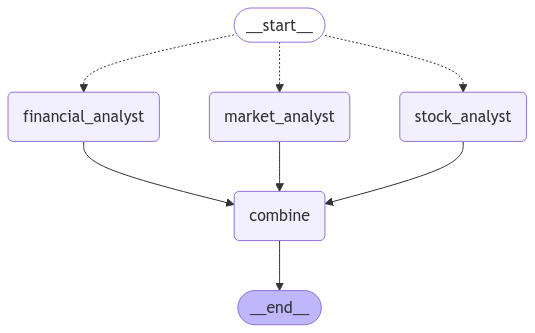

In [6]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
#10. example
config = {"recursion_limit": 50}
inputs = {
    "company": "Apple",
    "messages": [],
    "analyses": [],
    "combined_report": ""
}

for output in app.stream(inputs, config):
    if "__end__" not in output:
        print(output)
        print("---")

completed AAPL-StockFinancial(cik='0000320193', company_name='Apple Inc.', end_date='2024-09-28', filing_date=None, financials=Financials(balance_sheet={'other_noncurrent_assets': DataPoint(formula=None, label='Other Non-current Assets', order=350, unit='USD', value=166313000000.0, xpath=None), 'inventory': DataPoint(formula=None, label='Inventory', order=230, unit='USD', value=7286000000.0, xpath=None), 'equity': DataPoint(formula=None, label='Equity', order=1400, unit='USD', value=56950000000.0, xpath=None), 'other_current_liabilities': DataPoint(formula=None, label='Other Current Liabilities', order=740, unit='USD', value=107432000000.0, xpath=None), 'accounts_payable': DataPoint(formula=None, label='Accounts Payable', order=710, unit='USD', value=68960000000.0, xpath=None), 'other_current_assets': DataPoint(formula=None, label='Other Current Assets', order=250, unit='USD', value=145701000000.0, xpath=None), 'current_liabilities': DataPoint(formula=None, label='Current Liabilities',


1 Failed download:

1 Failed download:

1 Failed download:

1 Failed download:

1 Failed download:
['NASDAQ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-01-01 -> 2024-12-15)')
['NASDAQ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-01-01 -> 2024-12-15)')
['NASDAQ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-01-01 -> 2024-12-15)')
['NASDAQ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-01-01 -> 2024-12-15)')
['NASDAQ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-01-01 -> 2024-12-15)')


Requesting AAPL from 2020-01-01 to 2024-12-15...
Requesting MSFT from 2020-01-01 to 2024-12-15...
Requesting GOOGL from 2020-01-01 to 2024-12-15...
Requesting AMZN from 2020-01-01 to 2024-12-15...
Requesting NFLX from 2020-01-01 to 2024-12-15...
completed AAPL-StockFinancial(cik='0000320193', company_name='Apple Inc.', end_date='2024-06-29', filing_date='2024-08-02', financials=Financials(balance_sheet={'fixed_assets': DataPoint(formula=None, label='Fixed Assets', order=320, unit='USD', value=44502000000.0, xpath=None), 'equity': DataPoint(formula=None, label='Equity', order=1400, unit='USD', value=66708000000.0, xpath=None), 'noncurrent_assets': DataPoint(formula=None, label='Noncurrent Assets', order=300, unit='USD', value=206177000000.0, xpath=None), 'current_liabilities': DataPoint(formula=None, label='Current Liabilities', order=700, unit='USD', value=131624000000.0, xpath=None), 'long_term_debt': DataPoint(formula=None, label='Long-term Debt', order=810, unit='USD', value=9830000